In [ ]:
# Author: Antti Kiviaho
# Date: 20.1.2023
# A script for running normalization and sample integration clustering.
# Uses the scbi integration environment and pipeline:
#
#
# 1. Cell and gene filtering
# 2. scran normalization through R interface using
# 3. batch-aware scaling with scib
# 4. batch-aware HVGs with scib
# 5. scanorama integration into PCA, clustering, UMAP

In [ ]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import seaborn as sns
import scib
import scanorama

import matplotlib.pyplot as plt
from scripts.utils import get_sample_ids, qc_and_normalize

In [ ]:
# Download data from spaceranger output files in bulk
samples = get_sample_ids()
adata_dict = {}
for idx,sample_id in enumerate(samples):
    adata_sample = sc.read_visium('./results/'+sample_id+'/outs/',library_id=sample_id)
    adata_sample.var_names_make_unique()
    adata_dict[sample_id] = adata_sample

In [ ]:
# Produce QC plots as done at https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html
# Save the QC plots to a path
from pathlib import Path
dir_path = './plots/qc-plots-for-spatial-sections'
Path(dir_path).mkdir(parents=True, exist_ok=True)
for name in samples:
    adata = adata_dict[name]
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )
    fig.tight_layout()
    fig.set_dpi(200)
    plt.savefig(dir_path+'/'+name+'_qc_metrics'+'.png')
    plt.clf()

In [ ]:
def qc_and_normalize(adata):
    # requires scib-pipline-R4.0 conda environment !
    import scib
    # normalize and calculate leiden clustering
    sc.pp.filter_genes(adata, min_cells=5)
    sc.pp.filter_cells(adata, min_counts=500)
    scib.preprocessing.normalize(adata,precluster=False)
    return adata

In [11]:
for sample_id in samples:
    adata = adata_dict[sample_id]
    adata = qc_and_normalize(adata)

    # add ids to the data for use after data concatenation
    adata_dict[sample_id].obs['sample_id'] = sample_id
    adata_dict[sample_id].obs_names = sample_id + '_' + adata_dict[sample_id].obs_names

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:266: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/numpy2ri.py:208: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/rpy2/robjects/vectors.py:983: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2192: PytzUsageWarning: The zone attribute is specific to pytz's int

Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalization.
Note! Performing log1p-transformation after normalizatio

In [17]:
from scripts.utils import save_to_pickle
save_to_pickle(adata_dict,'normalized_visium_data.pickle')

In [32]:
adata_concat = sc.concat(adata_dict)
adata_concat.obs.sample_id = adata_concat.obs.sample_id.astype('category')
scib.preprocessing.scale_batch(adata_concat,batch='sample_id')
hvg_list = scib.preprocessing.hvg_batch(adata_concat,batch_key='sample_id',target_genes=3000,flavor='seurat',adataOut=False)

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scib/preprocessing.py:388: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_scaled.layers[key] = tmp[key]


Using 27 HVGs from full intersect set
Using 33 HVGs from n_batch-1 set
Using 56 HVGs from n_batch-2 set
Using 64 HVGs from n_batch-3 set
Using 83 HVGs from n_batch-4 set
Using 104 HVGs from n_batch-5 set
Using 151 HVGs from n_batch-6 set
Using 203 HVGs from n_batch-7 set
Using 280 HVGs from n_batch-8 set
Using 426 HVGs from n_batch-9 set
Using 627 HVGs from n_batch-10 set
Using 943 HVGs from n_batch-11 set
Using 3 HVGs from n_batch-12 set
Using 3000 HVGs


['HBA2',
 'IGHG3',
 'IGHG1',
 'JCHAIN',
 'IGHA1',
 'IGKC',
 'MYH11',
 'TPM2',
 'ACTG2',
 'DES',
 'LYZ',
 'SYNPO2',
 'TPSB2',
 'TAGLN',
 'CTGF',
 'FLNC',
 'CLU',
 'VWF',
 'MGP',
 'MT-ATP8',
 'MYLK',
 'LMOD1',
 'CALD1',
 'SYNM',
 'SAMHD1',
 'SMTN',
 'MRVI1',
 'NEXN',
 'RGS5',
 'PRRX1',
 'PPP1R12B',
 'PRELP',
 'FN1',
 'TNS1',
 'FILIP1L',
 'CCDC80',
 'ZBTB20',
 'PALLD',
 'ITGA1',
 'MAP1B',
 'THBS2',
 'SFRP4',
 'COL1A2',
 'FHL1',
 'CRYAB',
 'MCAM',
 'ACTA2',
 'IGF1',
 'RNASE1',
 'IGHM',
 'THBS1',
 'UACA',
 'CCL2',
 'PTGIS',
 'CFD',
 'CNN1',
 'PPP1R14A',
 'IGLC3',
 'ADAMTS1',
 'PCP4',
 'C1QB',
 'CD52',
 'PODN',
 'ANKRD36C',
 'ZEB2',
 'NRP2',
 'MTRNR2L12',
 'COL8A1',
 'SPARCL1',
 'SPP1',
 'FYB1',
 'CXCL14',
 'CARMN',
 'HIST1H4C',
 'HIST1H1E',
 'CFB',
 'HLA-DRA',
 'DST',
 'AKAP12',
 'SYNE1',
 'AGR2',
 'INHBA',
 'ELN',
 'TRBC2',
 'CHRDL1',
 'FLNA',
 'SFRP1',
 'SULF1',
 'PTGDS',
 'HBB',
 'C11orf96',
 'ITGA8',
 'MSMB',
 'SORBS1',
 'A2M',
 'KRT7',
 'IGFBP6',
 'ITGA5',
 'MSRB3',
 'PPP1R12A',
 'HSPB

In [35]:
adata_concat

AnnData object with n_obs × n_vars = 32664 × 12834
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'size_factors', 'sample_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'counts'

In [38]:
adata_scanorama = scib.integration.scanorama(adata_concat,batch='sample_id',hvg=hvg_list)

Found 12834 genes among all datasets
[[0.00000000e+00 1.59405941e-01 5.03840246e-01 0.00000000e+00
  6.83315622e-01 0.00000000e+00 1.18655241e-02 0.00000000e+00
  1.08910891e-02 0.00000000e+00 4.95049505e-04 0.00000000e+00
  0.00000000e+00 3.61386139e-02 4.21585160e-03 1.25628141e-03
  1.19801980e-01]
 [0.00000000e+00 0.00000000e+00 1.97388633e-01 8.65051903e-03
  2.23166844e-02 7.17875090e-04 2.10942650e-02 2.25352113e-03
  1.97497280e-01 1.35317997e-03 8.83054893e-03 2.32883093e-03
  1.77981185e-02 2.10784314e-02 5.98650927e-02 6.97236181e-02
  5.22531160e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.73010381e-03
  4.88841658e-02 3.60983103e-02 4.41661173e-02 4.60829493e-03
  3.07219662e-02 0.00000000e+00 6.91244240e-03 7.68049155e-04
  0.00000000e+00 1.22549020e-02 9.52782462e-02 5.37634409e-03
  1.68202765e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.85813149e-01 3.95517469e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0000000

/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/scanorama/scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])
/home/ak431480/.conda/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [39]:
with open('visium_after_scanorama.pickle', 'wb') as handle:
    pickle.dump(adata_scanorama, handle, protocol=pickle.HIGHEST_PROTOCOL)
adata_scanorama

AnnData object with n_obs × n_vars = 32664 × 12834
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'size_factors', 'sample_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'spatial', 'X_scanorama', 'X_emb'

In [45]:
sc.pp.neighbors(adata_scanorama, use_rep="X_scanorama")
sc.tl.umap(adata_scanorama)
sc.tl.leiden(adata_scanorama, key_added="clusters")

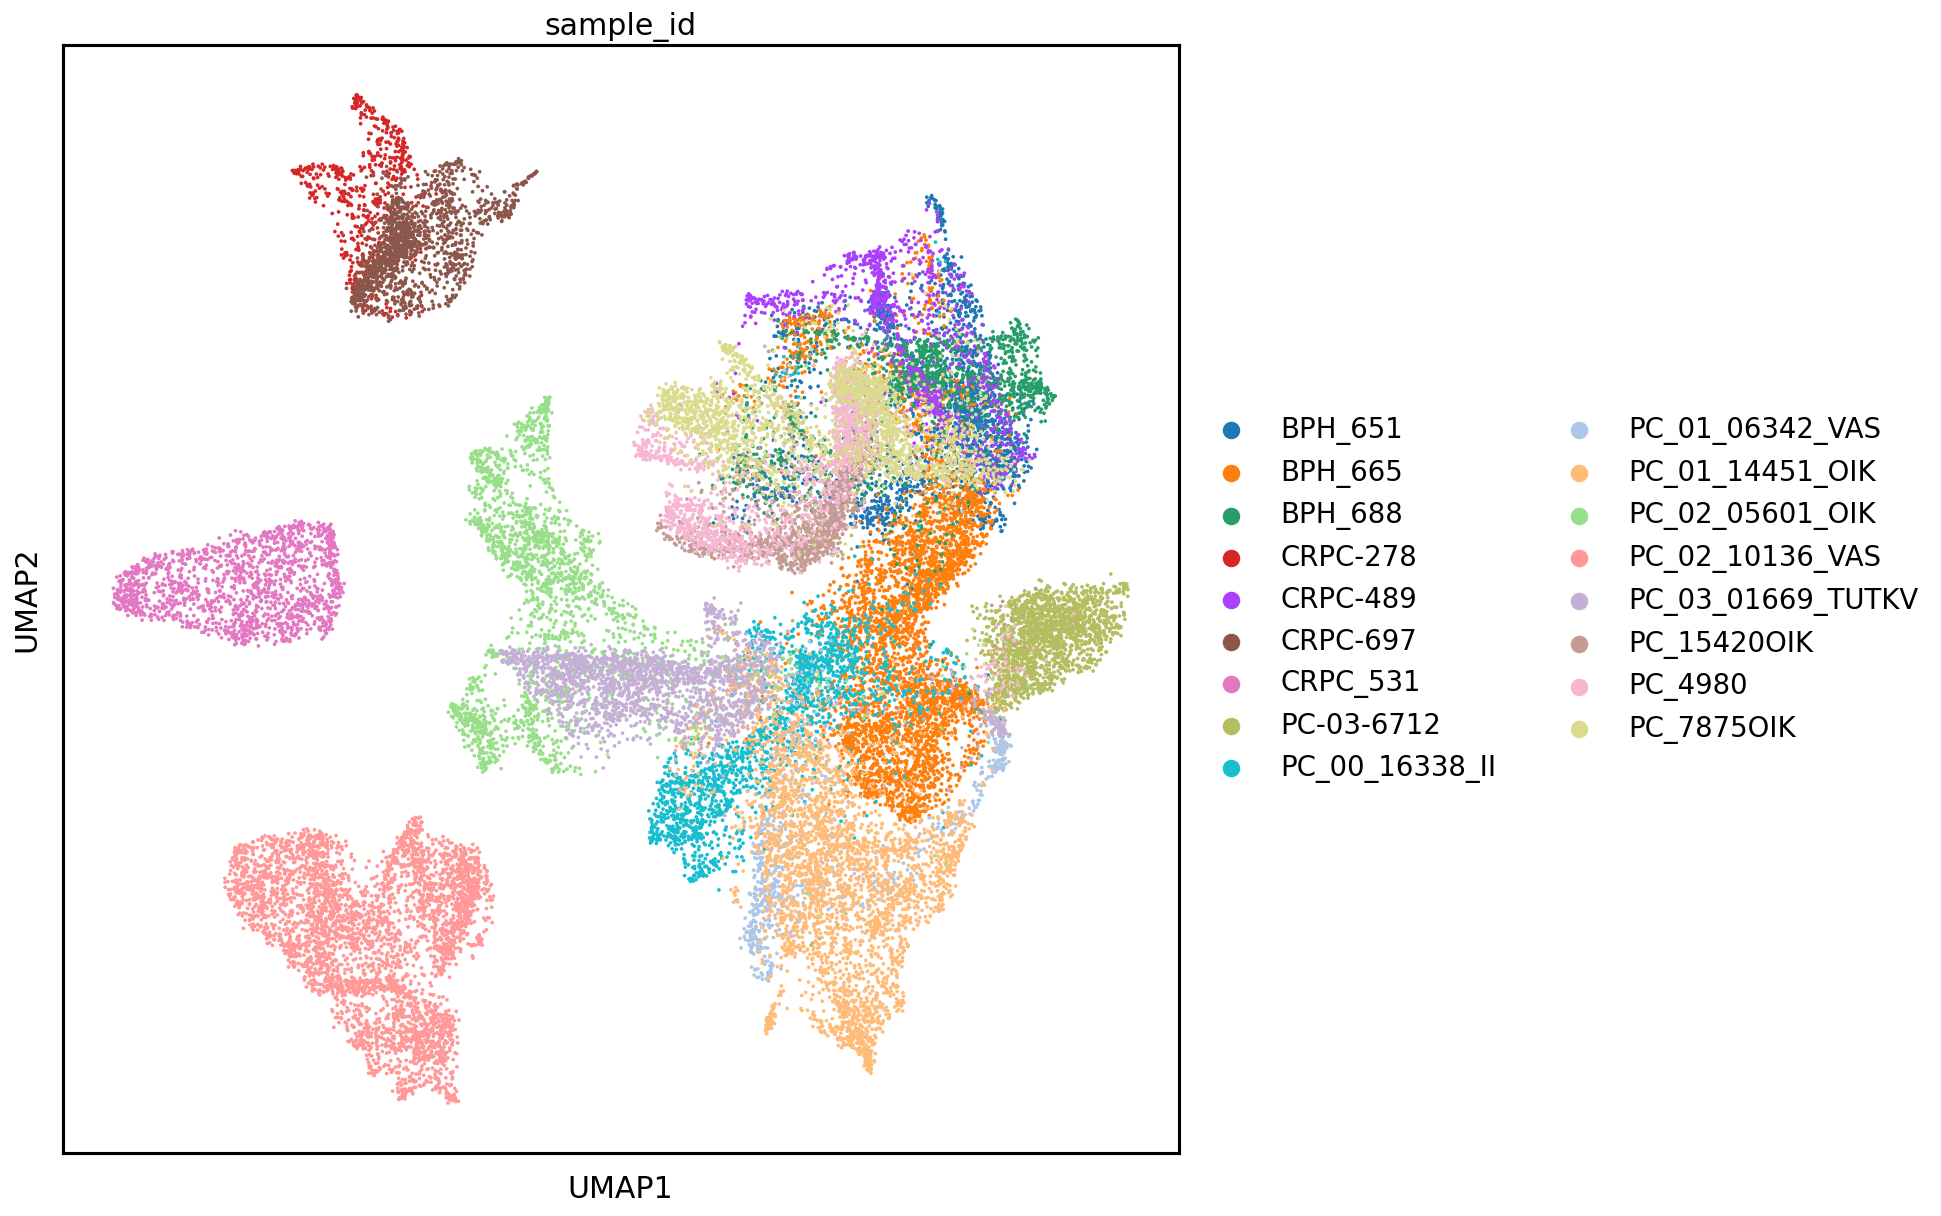

In [52]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,12)
fig.set_dpi(120)
sc.pl.umap(adata_scanorama, color=["sample_id"],ax=ax1,size=20)

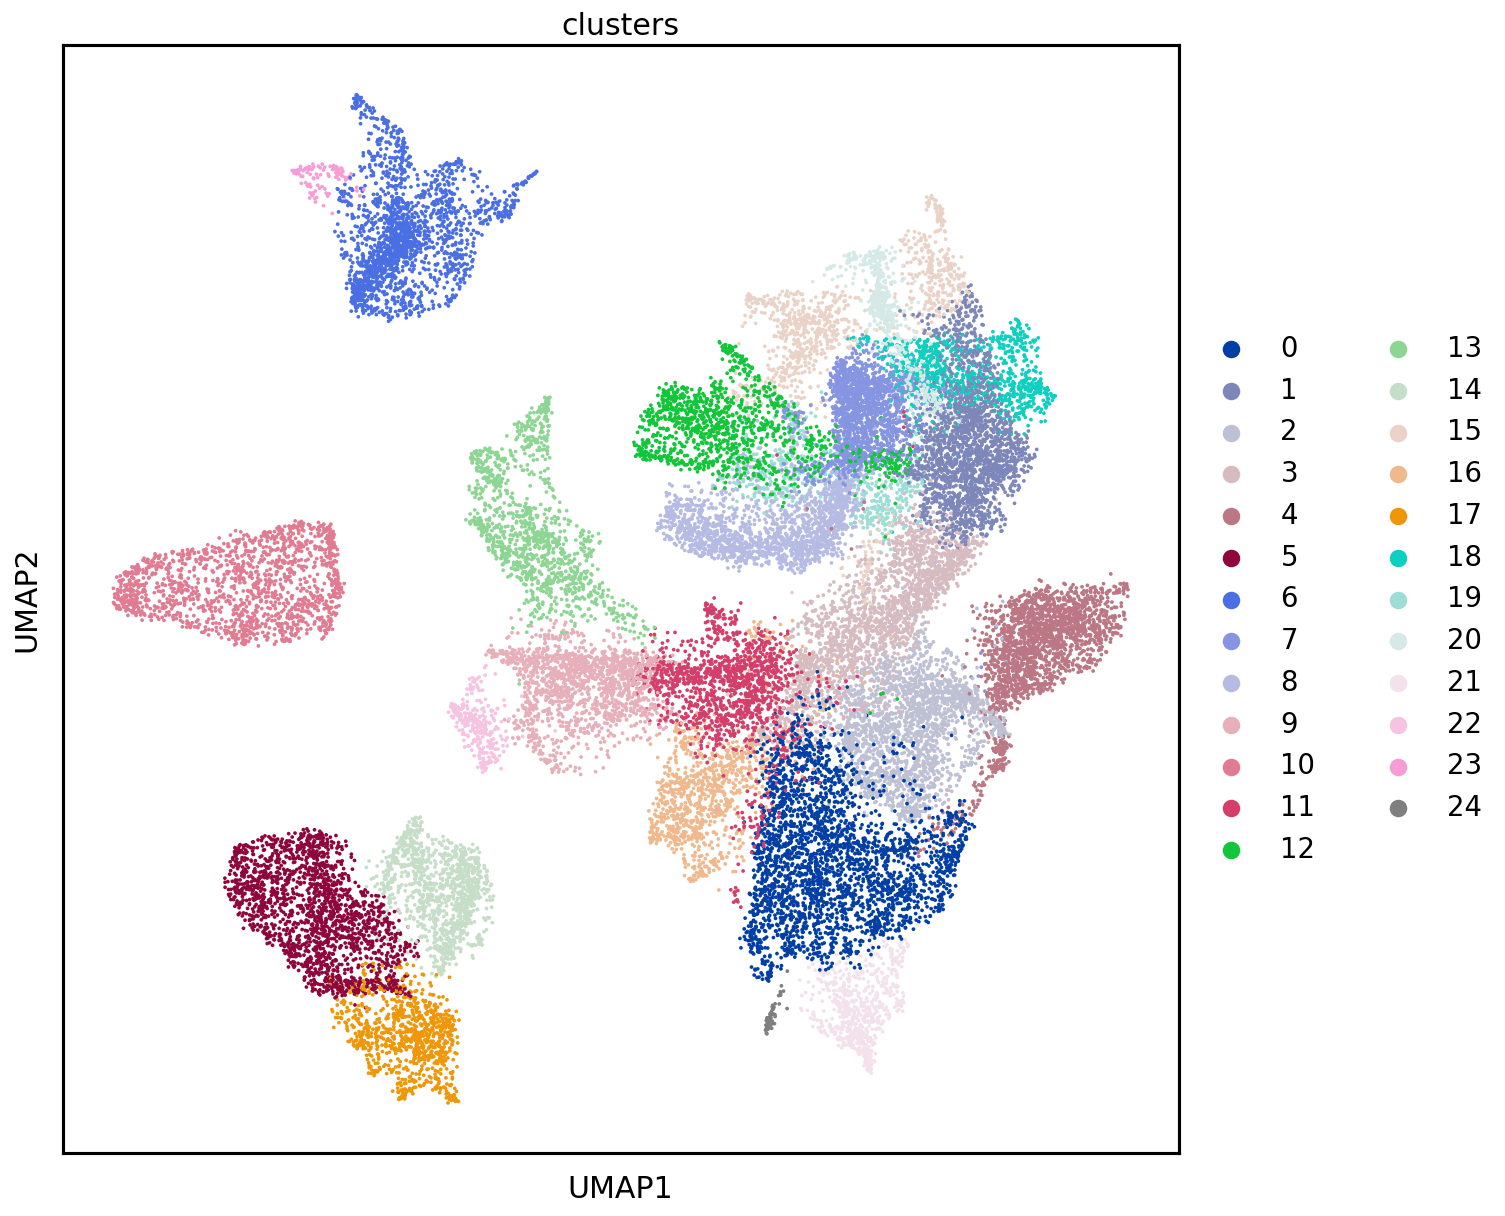

In [53]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,12)
fig.set_dpi(120)
sc.pl.umap(adata_scanorama, color=["clusters"],ax=ax1,size=20)

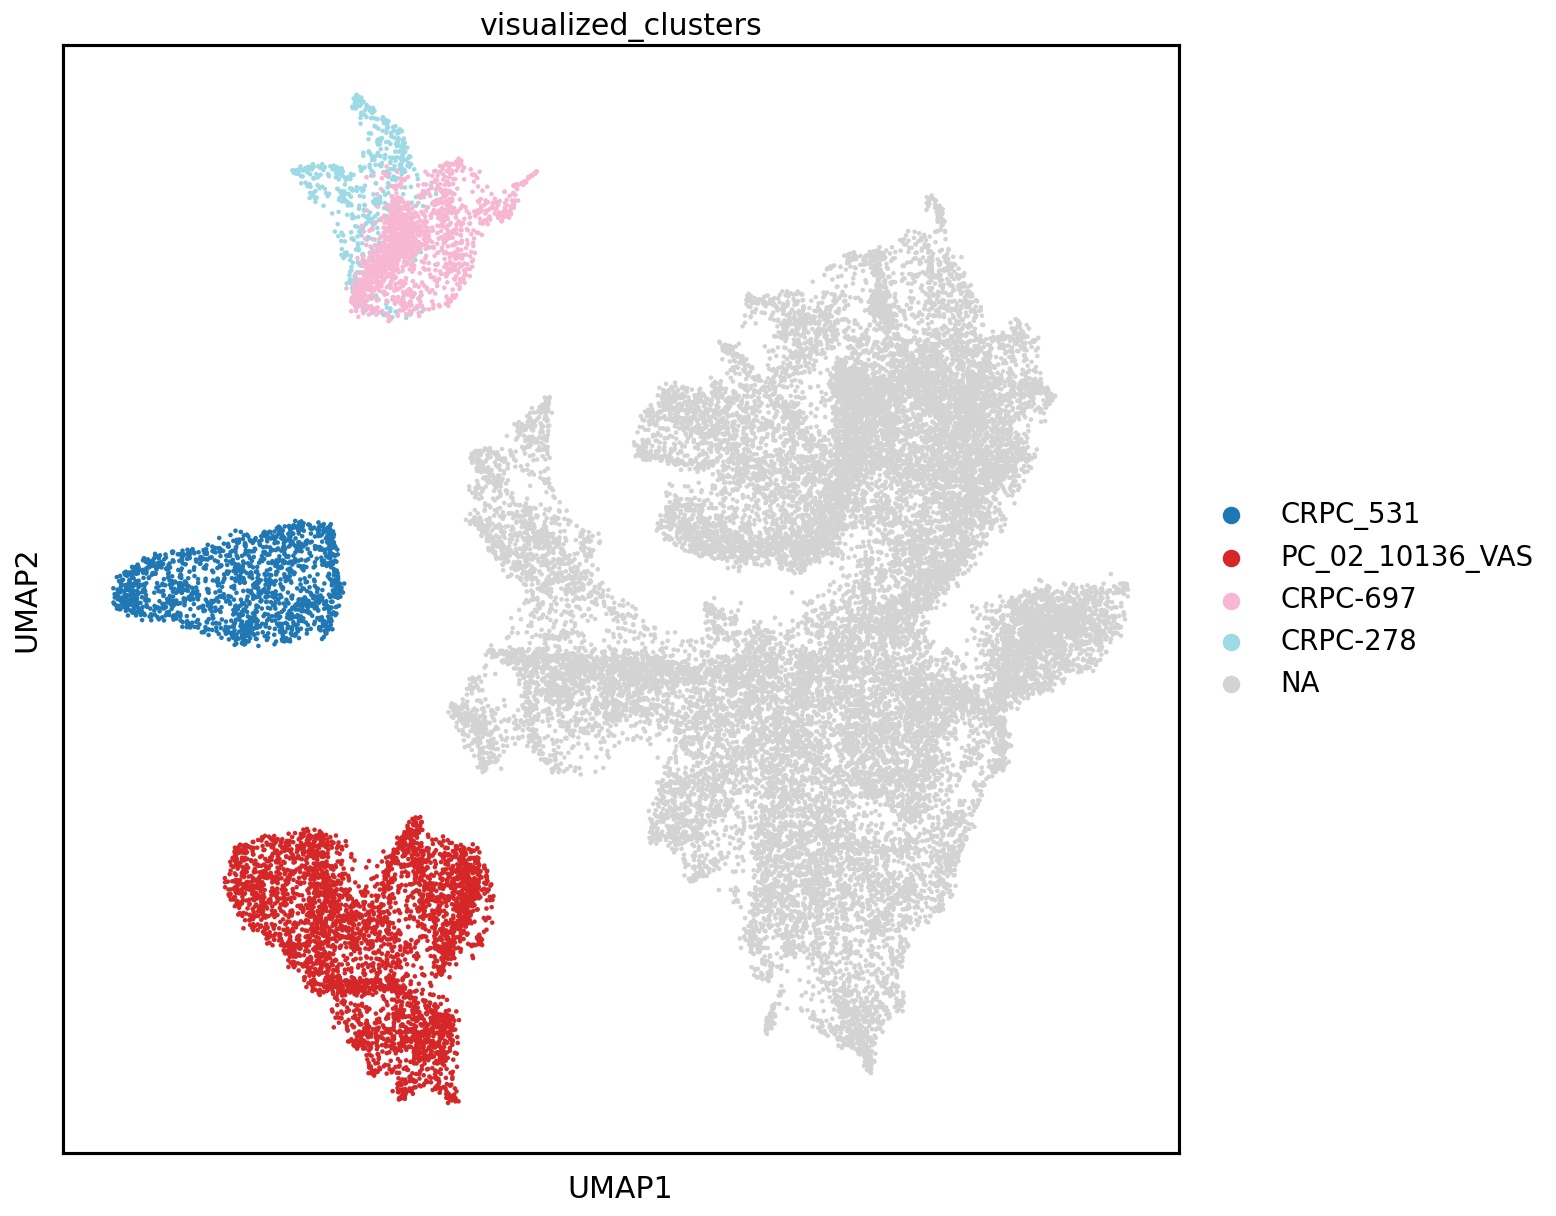

In [56]:
targets = ['CRPC_531','PC_02_10136_VAS','CRPC-697','CRPC-278']
adata_scanorama.obs['visualized_clusters'] = adata_scanorama.obs['sample_id'][adata_scanorama.obs['sample_id'].isin(targets)]
adata_scanorama.obs['visualized_clusters'] = adata_scanorama.obs['visualized_clusters'].cat.set_categories(targets)

fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(12,12)
fig.set_dpi(120)
sc.pl.umap(adata_scanorama, color=['visualized_clusters'],ax=ax1,size=30,palette='tab20')